In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import linear_model, model_selection, metrics

import matplotlib.pyplot as plt

import sys
sys.path.insert(1, "../src/")
from material import Material
from materialsdataset import MaterialsDataset
from periodictable import PeriodicTable
from materialspredictiondata import MaterialsPredictionData
from bandgapdataset import BandGapDataset
from bandgapdataframe import BandGapDataFrame

In [2]:
csv_path = "../data/training/materialsproject_output/"
json_path = "../data/training/materialsproject_json/"

### MaterialsPredictionData class
- the user creates an object of this type to use the package
- takes in a MaterialsDatset type object which contains materials and their params to use for prediction
- houses array of data to run through the model to predict the bandgap
- also houses information needed to create the correct training data based on the user input

In [3]:
Si3Ge4 = Material(formula="Si3Ge4",density=1.23,volume=57)
Cd22S45 = Material(formula="Cd22S45",density=2.34)
SiGe = Material(formula="SiGe",density=3.824,volume=43.741,formation_energy=0.024,
                crystal_system="cubic",spacegroup="F43m") #taken from mp-1219182

print(Si3Ge4.training_params)
print(Cd22S45.training_params)
print(SiGe.training_params)

['volume', 'density__gm_per_cc']
['density__gm_per_cc']
['spacegroup', 'formation_energy__eV', 'volume', 'density__gm_per_cc', 'crystal_system']


In [4]:
material_dataset = MaterialsDataset([Si3Ge4,Cd22S45,SiGe])

In [5]:
material_dataset.materials_dict["SiGe"]

{'params': {'spacegroup': 'F43m',
  'formation_energy__eV': 0.024,
  'E_above_hull__eV': None,
  'volume': 43.741,
  'Nsites': None,
  'density__gm_per_cc': 3.824,
  'crystal_system': 'cubic'},
 'stoichiometry': {'Si': 0.5, 'Ge': 0.5}}

In [6]:
periodic_table = PeriodicTable()
symbol_to_element_map = periodic_table.symbol_to_element_map
symbols = periodic_table.symbols

In [7]:
materials_prediction_data = MaterialsPredictionData(material_dataset,symbols)

In [8]:
print(materials_prediction_data.prediction_data["SiGe"])

['F43m', 0.024, 43.741, 3.824, 'cubic', 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [9]:
materials_to_predict = list(materials_prediction_data.prediction_data.keys())
materials_to_predict

['Si3Ge4', 'Cd22S45', 'SiGe']

### BandGapDataset class
- need to create unique one for each material, as each material can have unique input parameters

Si3Ge4
-------------
params: ['volume', 'density__gm_per_cc']

X_train shape: (1059, 120)
y_train shape: (1059,)
 X_test shape: (522, 120)
 y_test shape: (522,)

Model Score: 0.3069951638594065


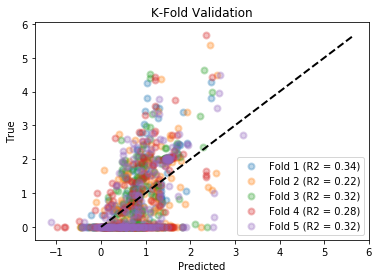

Si3Ge4's predicted bandgap = 0.7952213239029361 eV

Cd22S45
-------------
params: ['density__gm_per_cc']

X_train shape: (1059, 119)
y_train shape: (1059,)
 X_test shape: (522, 119)
 y_test shape: (522,)

Model Score: 0.25053123813817346


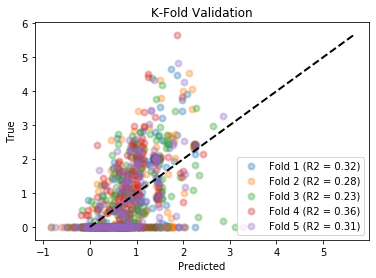

Cd22S45's predicted bandgap = 1.281214671325621 eV

SiGe
-------------
params: ['spacegroup', 'formation_energy__eV', 'volume', 'density__gm_per_cc', 'crystal_system']

X_train shape: (1059, 123)
y_train shape: (1059,)
 X_test shape: (522, 123)
 y_test shape: (522,)

Model Score: 0.4143497996107661


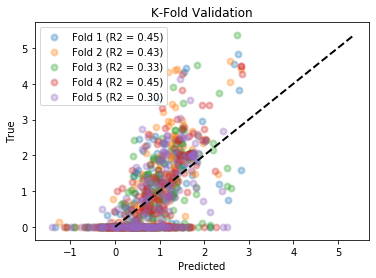

SiGe's predicted bandgap = 0.5198618367773999 eV



In [10]:
for material in materials_to_predict:
    print(f"{material}")
    print("-------------")
    dataset = BandGapDataset(csv_path,json_path)
    data_dict = dataset.data_dict
    data_IDs = dataset.data_IDs
    
    material_training_params = [ 
        param for (param,value) in material_dataset.materials_dict[material]["params"].items() if value is not None
    ]
    
    bandgap_dataframe = BandGapDataFrame(data_dict, symbols, material_training_params)
    dataframe = bandgap_dataframe.dataframe
    non_element_keys = bandgap_dataframe.non_element_keys 
        
    # mapping non-numeric params to numeric values which were created
    # during the creation of the training data
    non_numeric_params = {
        "crystal_system": bandgap_dataframe.crystal_system_map,
        "spacegroup":bandgap_dataframe.spacegroup_map,
    }
    for param, bandgap_map in non_numeric_params.items():
        if param in material_training_params:
            idx = material_training_params.index(param)
            value = materials_prediction_data.prediction_data[material][idx]
            materials_prediction_data.prediction_data[material][idx] = bandgap_map[value]            
    
    print(f"params: {non_element_keys[1:]}\n")
    
    X_keys = list(dataframe.keys())[2:]
    X = np.asarray(dataframe[X_keys])
    y = np.asarray(dataframe['band_gap__eV'])
            
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle= True)
    
    print(f"X_train shape: {np.shape(X_train)}")
    print(f"y_train shape: {np.shape(y_train)}")
    print(f" X_test shape: {np.shape(X_test)}")
    print(f" y_test shape: {np.shape(y_test)}\n")
    
    model = linear_model.Ridge(alpha = .5)
    model.fit(X_train, y_train)
    print(f"Model Score: {model.score(X_test, y_test)}")
    #print('Weights: ', model.coef_)

    
    
    # K fold validation
    # https://towardsdatascience.com/machine-learning-with-python-regression-complete-tutorial-47268e546cea
    scores = []
    cv = model_selection.KFold(n_splits=5, shuffle=True)
    fig = plt.figure()
    i = 1

    for train, test in cv.split(X_train, y_train):
        prediction = model.fit(X_train[train],
                     y_train[train]).predict(X_train[test])
        true = y_train[test]
        score = metrics.r2_score(true, prediction)
        scores.append(score)
        plt.scatter(prediction, true, lw=2, alpha=0.3, 
                    label='Fold %d (R2 = %0.2f)' % (i,score))
        i = i+1
    plt.plot([min(y_train),max(y_train)], [min(y_train),max(y_train)], 
             linestyle='--', lw=2, color='black')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('K-Fold Validation')
    plt.legend()
    plt.show()
    
    # predicting the bandgap
    this_prediction_data = np.asarray(materials_prediction_data.prediction_data[material])
    this_prediction_data = np.reshape(this_prediction_data, (1,np.shape(this_prediction_data)[0]))
        
    band_gap_prediction = model.predict(this_prediction_data)[0]
    print(f"{material}'s predicted bandgap = {band_gap_prediction} eV\n")